# U-Net Training with CamVid Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from unet_model import UNet
import pandas as pd
import torchvision.transforms as T

## Dataset Preparation

In [2]:
def rgb_to_class(mask_np, colormap):
    """Convert HxWx3 RGB mask to HxW class index mask."""
    h, w, _ = mask_np.shape
    mask_class = np.zeros((h, w), dtype=np.int64)

    # Convert to structured array for fast comparison
    mask_reshaped = mask_np.reshape(-1, 3)

    # Precompute colors
    colors = np.array(list(colormap.keys()))
    class_ids = np.array(list(colormap.values()))

    # For each pixel, find which color matches
    # This uses broadcasting → VERY fast
    matches = (mask_reshaped[:, None, :] == colors[None, :, :]).all(-1)
    mask_class = class_ids[matches.argmax(axis=1)].reshape(h, w)

    return mask_class

In [3]:
class StanfordBGDataset(Dataset):
    def __init__(self, csv_path, colormap, img_size=(128, 128)):
        self.df = pd.read_csv(csv_path)
        self.colormap = colormap
        self.img_size = img_size
        
        self.img_transform = T.Compose([
            T.Resize(img_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.mask_resize = T.Resize(img_size, interpolation=T.InterpolationMode.NEAREST)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img = Image.open(row["image_path"]).convert("RGB")
        img = self.img_transform(img)

        mask = Image.open(row["label_colored_path"]).convert("RGB")
        mask = self.mask_resize(mask)
        mask_np = np.array(mask)
        mask_class = rgb_to_class(mask_np, self.colormap)
        
        mask_tensor = torch.from_numpy(mask_class).long()
        
        return img, mask_tensor
    
    def parse_regions_txt(self, txt_path):
        """Parse .regions.txt file into class mask"""
        with open(txt_path, 'r') as f:
            lines = f.readlines()
        
        width, height = map(int, lines[0].strip().split())
        mask = np.zeros((height, width), dtype=np.int64)
        
        for i, line in enumerate(lines[1:]):
            row_labels = list(map(int, line.strip().split()))
            mask[i, :len(row_labels)] = row_labels
        
        return mask

## CPU Configuration

In [4]:
# CONFIGURATION
BATCH_SIZE = 8
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
IMG_SIZE = 128
NUM_CLASSES = 8
DEVICE = torch.device('cpu')
NUM_WORKERS = 0

print(f"Using device: {DEVICE}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")

Using device: cpu
Image size: 128x128
Batch size: 8
Epochs: 10


In [5]:
def load_stanford_colormap(csv_path):
    df = pd.read_csv(csv_path)
    colormap = {}
    for idx, row in df.iterrows():
        rgb = (int(row['r']), int(row['g']), int(row['b']))
        colormap[rgb] = idx  # class index
    return colormap

# Load the colormap
STANFORD_COLORMAP = load_stanford_colormap("..\dataset\deeplearning\labels_class_dict.csv")
NUM_CLASSES = len(STANFORD_COLORMAP)

print(f"Loaded {NUM_CLASSES} classes")

Loaded 9 classes


In [6]:
def rgb_to_class(mask_np, colormap):
    """Convert HxWx3 RGB mask to HxW class index mask."""
    h, w, _ = mask_np.shape
    mask_class = np.zeros((h, w), dtype=np.int64)

    # Convert to structured array for fast comparison
    mask_reshaped = mask_np.reshape(-1, 3)

    # Precompute colors
    colors = np.array(list(colormap.keys()))
    class_ids = np.array(list(colormap.values()))

    # For each pixel, find which color matches
    # This uses broadcasting → VERY fast
    matches = (mask_reshaped[:, None, :] == colors[None, :, :]).all(-1)
    mask_class = class_ids[matches.argmax(axis=1)].reshape(h, w)

    return mask_class

In [7]:
def rgb_to_class(mask_np, colormap):
    """Convert HxWx3 RGB mask to HxW class index mask."""
    h, w, _ = mask_np.shape
    mask_class = np.zeros((h, w), dtype=np.int64)

    # Convert to structured array for fast comparison
    mask_reshaped = mask_np.reshape(-1, 3)

    # Precompute colors
    colors = np.array(list(colormap.keys()))
    class_ids = np.array(list(colormap.values()))

    # For each pixel, find which color matches
    # This uses broadcasting → VERY fast
    matches = (mask_reshaped[:, None, :] == colors[None, :, :]).all(-1)
    mask_class = class_ids[matches.argmax(axis=1)].reshape(h, w)

    return mask_class

In [8]:
def rgb_to_class(mask_np, colormap):
    """Convert HxWx3 RGB mask to HxW class index mask."""
    h, w, _ = mask_np.shape
    mask_class = np.zeros((h, w), dtype=np.int64)

    # Convert to structured array for fast comparison
    mask_reshaped = mask_np.reshape(-1, 3)

    # Precompute colors
    colors = np.array(list(colormap.keys()))
    class_ids = np.array(list(colormap.values()))

    # For each pixel, find which color matches
    # This uses broadcasting → VERY fast
    matches = (mask_reshaped[:, None, :] == colors[None, :, :]).all(-1)
    mask_class = class_ids[matches.argmax(axis=1)].reshape(h, w)

    return mask_class

## Load Dataset

In [9]:
# Split metadata into train/val
import pandas as pd
from sklearn.model_selection import train_test_split

# Load metadata
metadata_df = pd.read_csv("../dataset/deeplearning/metadata.csv")

# Split 80% train, 20% val
train_df, val_df = train_test_split(metadata_df, test_size=0.2, random_state=42)

# Save splits
train_df.to_csv("stanford_train.csv", index=False)
val_df.to_csv("stanford_val.csv", index=False)

print(f"Train: {len(train_df)} images")
print(f"Val: {len(val_df)} images")

Train: 572 images
Val: 143 images


In [10]:
train_dataset = StanfordBGDataset(
    "stanford_train.csv",
    STANFORD_COLORMAP,
    img_size=(IMG_SIZE, IMG_SIZE)
)

val_dataset = StanfordBGDataset(
    "stanford_val.csv",
    STANFORD_COLORMAP,
    img_size=(IMG_SIZE, IMG_SIZE)
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 572
Validation samples: 143


In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

## Initialize Model

In [12]:
model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 31,044,041


## Training Functions

In [13]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(dataloader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    return running_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    return running_loss / len(dataloader), correct_pixels / total_pixels

## Training

In [14]:
import time
from datetime import datetime, timedelta

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
best_val_loss = float('inf')

print("="*60)
print(f"Training started at: {datetime.now().strftime('%H:%M:%S')}")
print(f"Expected finish: ~{(datetime.now() + timedelta(hours=5)).strftime('%H:%M:%S')}")
print("="*60)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_accuracy = validate(model, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    epoch_time = time.time() - epoch_start
    remaining_time = epoch_time * (NUM_EPOCHS - epoch - 1) / 60
    
    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f}")
    print(f"Epoch time: {epoch_time/60:.1f} minutes")
    print(f"Estimated remaining: {remaining_time:.1f} minutes")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
        }, 'unet_best.pth')
        print("Saved best model!")

total_time = (time.time() - start_time) / 60
print(f"\n{'='*60}")
print(f"Training completed in {total_time:.1f} minutes ({total_time/60:.2f} hours)!")
print(f"Best validation accuracy: {max(history['val_accuracy']):.4f}")
print(f"Model saved as: unet_best.pth")
print(f"{'='*60}")

Training started at: 22:28:32
Expected finish: ~03:28:32

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:26<00:00,  1.46s/it, loss=1.1558]



Train Loss: 1.2661
Val Loss: 1.1166
Val Accuracy: 0.6036
Epoch time: 5.5 minutes
Estimated remaining: 49.9 minutes
Saved best model!

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:21<00:00,  1.19s/it, loss=0.9009]



Train Loss: 1.0125
Val Loss: 0.9810
Val Accuracy: 0.6656
Epoch time: 6.5 minutes
Estimated remaining: 52.3 minutes
Saved best model!

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it, loss=0.8451]



Train Loss: 0.9444
Val Loss: 0.9373
Val Accuracy: 0.6884
Epoch time: 4.8 minutes
Estimated remaining: 33.7 minutes
Saved best model!

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it, loss=0.7733]



Train Loss: 0.9090
Val Loss: 0.8462
Val Accuracy: 0.7185
Epoch time: 4.6 minutes
Estimated remaining: 27.9 minutes
Saved best model!

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it, loss=0.7788]



Train Loss: 0.8618
Val Loss: 0.8508
Val Accuracy: 0.7166
Epoch time: 4.6 minutes
Estimated remaining: 22.8 minutes

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:22<00:00,  1.25s/it, loss=0.7705]



Train Loss: 0.8290
Val Loss: 0.8584
Val Accuracy: 0.7102
Epoch time: 4.9 minutes
Estimated remaining: 19.4 minutes

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it, loss=0.8067]



Train Loss: 0.8232
Val Loss: 0.8537
Val Accuracy: 0.7148
Epoch time: 12.8 minutes
Estimated remaining: 38.4 minutes

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it, loss=0.8488]



Train Loss: 0.7494
Val Loss: 0.8238
Val Accuracy: 0.7164
Epoch time: 4.4 minutes
Estimated remaining: 8.7 minutes
Saved best model!

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it, loss=0.8294]



Train Loss: 0.7472
Val Loss: 0.8255
Val Accuracy: 0.7205
Epoch time: 4.6 minutes
Estimated remaining: 4.6 minutes

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:23<00:00,  1.30s/it, loss=0.7701]



Train Loss: 0.7247
Val Loss: 0.7803
Val Accuracy: 0.7426
Epoch time: 4.6 minutes
Estimated remaining: 0.0 minutes
Saved best model!

Training completed in 57.4 minutes (0.96 hours)!
Best validation accuracy: 0.7426
Model saved as: unet_best.pth


## Training Results

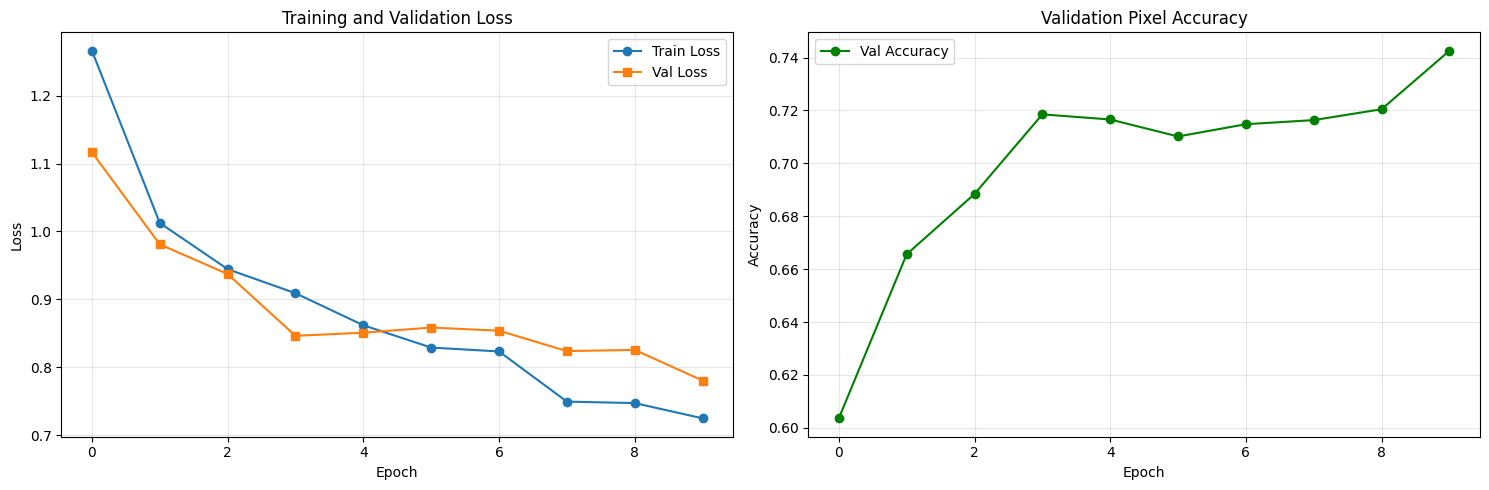


Final Results:
  Best Val Loss: 0.7803
  Best Val Accuracy: 0.7426


In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['val_accuracy'], label='Val Accuracy', color='green', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Pixel Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

print(f"\nFinal Results:")
print(f"  Best Val Loss: {min(history['val_loss']):.4f}")
print(f"  Best Val Accuracy: {max(history['val_accuracy']):.4f}")

## Visualize Predictions

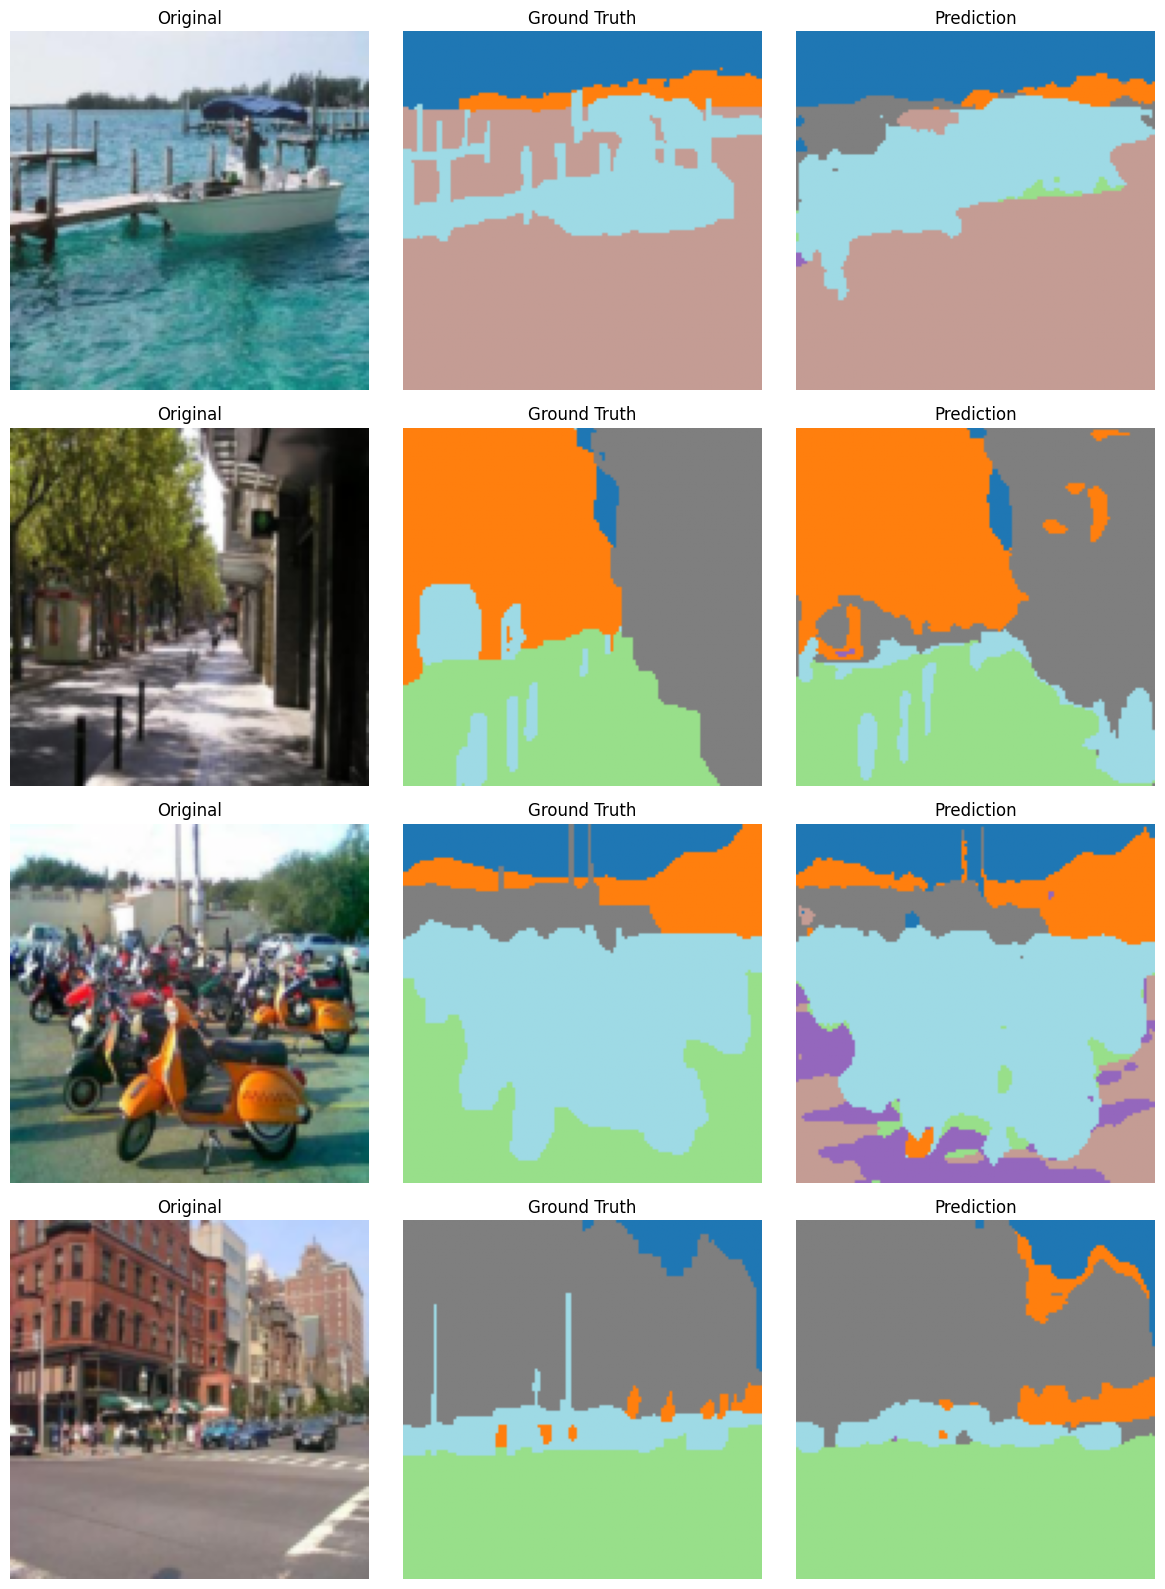

Visualization saved!


In [16]:
checkpoint = torch.load('unet_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

dataiter = iter(val_loader)
images, masks = next(dataiter)

with torch.no_grad():
    images_cpu = images.to(DEVICE)
    outputs = model(images_cpu)
    preds = outputs.argmax(dim=1).cpu().numpy()

images = images.cpu()
masks = masks.cpu().numpy()

# Denormalize
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images = images * std + mean
images = torch.clamp(images, 0, 1)

num_samples = min(4, len(images))
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    axes[i, 0].imshow(images[i].permute(1, 2, 0))
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(masks[i], cmap='tab20', vmin=0, vmax=7)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(preds[i], cmap='tab20', vmin=0, vmax=7)
    axes[i, 2].set_title('Prediction')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('predictions_sample.png', dpi=150)
plt.show()

print("Visualization saved!")